# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import sdeint
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import pysindy as ps
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import seaborn as sns
import random
import math


In [2]:
# parameters
data_length = 500
train_test_depth = 500 # length of perturbation for training and testing
desired_depth = 500 # length of desired signal during controlled
t1 = 200# number of points to wait 
t2 = 400 # number of points to wait until controlled begins
# setting number of identification(1500)
train_pts_id = 1200
test_pts_id = 300
# setting number of training and testing points
train_pts = 200
test_pts = 200
# iteration 
time_array = np.arange(data_length)
dt = 0.01
t = dt * time_array
t_train =  np.arange(t2)
# Plot Parameters
fontsize = 20
ticksize = 20
nbinsx_attractor = 6
nbinsy_attractor = 8
nbinsx_time_series = 9
nbinsy_time_series = 5
box_linewidth = 1.5
tick_width = 1
tick_length= 7
attractor_color = 'darkviolet'
transient_color = 'silver'



In [3]:
# # 指定字体路径
# font_path = "C:/Windows/Fonts/simhei.ttf"  # 需要使用正斜杠或双反斜杠
# font_prop = fm.FontProperties(fname=font_path)

In [4]:
# # Silence all deprecation warnings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# Real EEG data

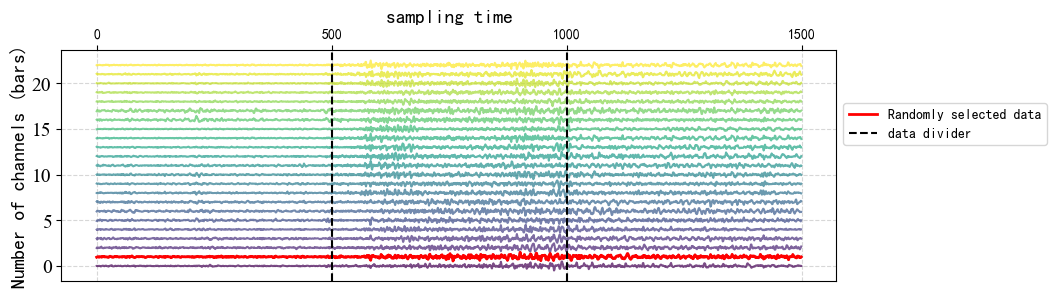

In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

fontsize = 14
# 读取数据并进行归一化
t_sample = 0.0625  # 采样频率
edata = pd.read_csv('data/edata_chb01_03.csv', header=None)

dm = pd.DataFrame()
dm['max'] = edata.max(axis=0)
dm['min'] = abs(edata.min(axis=0))
dm['did'] = dm[['max', 'min']].max(axis=1) * 2  # 计算缩放因子
predata = edata.div(dm['did'], axis='columns')  # 将数据缩放到 [-0.5, 0.5]

# 为不同电极信号增加偏移量
dm = pd.DataFrame()
dm['ad'] = np.arange(23)
predata1 = predata.add(dm['ad'], axis='columns')

# 提取数据
xxx = predata1.values
times = np.arange(len(xxx))

# 创建画布
plt.figure(figsize=(10, 3))
# plt.style.use('ggplot')  # 采用 Seaborn 风格

# 颜色映射
colors = plt.cm.viridis(np.linspace(0, 1, xxx.shape[1]))

# 绘制所有电极的信号
for i in range(xxx.shape[1]):
    plt.plot(times, xxx[:, i], color=colors[i], alpha=0.7)

# 突出显示某个特定通道
plt.plot(times, xxx[:, 1], color='red', linewidth=2, label='Randomly selected data')

# 添加垂直虚线
plt.axvline(x=data_length, linestyle='dashed', color='black', linewidth=1.5, label="data divider")
plt.axvline(x=data_length + desired_depth, linestyle='dashed', color='black', linewidth=1.5)

# 美化轴标签
plt.xlabel('sampling time', fontsize=fontsize)
plt.ylabel('Number of channels (bars)', fontsize=fontsize)

# 设置刻度样式
plt.xticks(fontsize=fontsize, fontname='Times New Roman')
plt.yticks(fontsize=fontsize, fontname='Times New Roman')

# 设置 x 轴的刻度间隔为 500
x_major_locator = MultipleLocator(500)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.5)

# 添加图例
# plt.legend(loc='upper right', fontsize=12, frameon=True)
plt.legend(bbox_to_anchor=(1, 0.8))
# 添加标题
# plt.title('EEG Signals (Normalized)', fontsize=18,
#  fontname='Times New Roman', fontweight='bold')
# 获取当前坐标轴
ax = plt.gca()

# 将 x 轴刻度和标签移动到顶部
ax.xaxis.set_label_position('top')  # 移动 x 轴标签到顶部
ax.xaxis.tick_top()  # 移动刻度到顶部

# 显示图像
plt.show()


In [6]:
# 假设 predata 已经是一个 DataFrame，形状为 (1000, n)，这里我们选择列 5 和 4
# x_original = predata.values[300:900, 1]
# x_target = predata.values[:600, 1]
data = predata.values[:, 1]
x_original = predata.values[500:1000, 1]
x_target = predata.values[:500, 1]

# # 4. gaussian 高斯滤波平滑
# sigma = 1  # 控制平滑程度，值越大越平滑
# x_target_smooth_g = gaussian_filter(x_target, sigma=sigma)
# x_original_smooth_g = gaussian_filter(x_original, sigma=sigma)


# # 绘制原始数据和光滑后的数据
# plt.figure(figsize=(12, 8))

# # x_original 和 y_original 图
# plt.subplot(2, 1, 1)
# plt.plot(x_original, label='original x_original', alpha=0.7)
# plt.plot(x_target_smooth_g, label='Gauss Smoothed x_original', linestyle='--')
# # plt.plot(x_original_smooth_sma, label='SMA Smoothed x_original', linestyle='--')
# # plt.plot(x_original_smooth_ema, label='EMA Smoothed x_original', linestyle='-.')
# # plt.plot(x_original_smooth_sg, label='Savitzky-Golay Smoothed x_original', linestyle=':')
# plt.title('x_original - original and Smoothed')
# plt.legend()

# # x_target 和 y_target 图
# plt.subplot(2, 1, 2)
# plt.plot(x_target, label='original x_target', alpha=0.7)
# plt.plot(x_target_smooth_g, label='Gauss Smoothed x_target', linestyle='--')
# # plt.plot(x_target_smooth_sma, label='SMA Smoothed x_target', linestyle='--')
# # plt.plot(x_target_smooth_ema, label='EMA Smoothed x_target', linestyle='-.')
# # plt.plot(x_target_smooth_sg, label='Savitzky-Golay Smoothed x_target', linestyle=':')
# plt.title('x_target - original and Smoothed')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [7]:
# original_data = x_original_smooth_g
original_data = x_original



In [8]:
def task_picker(task):
    """
    Create desired signals for use in the controlled algorithm.
    
    Parameters:
        task (int): The original task is chosen with task=1, the two USS task is 
        chosen with task=2, and the random task is chosen with task=3
        
    Returns:
        Y_desired (numpy.ndarray): controlledtains the desired signal in digital form
    """

    # original task
    if task == 1:
        
        # setting the desired trajectory to zero
        Y_desired = np.zeros(data_length)


    elif task == 2:
    
        # 取训练y的一半
        # Y_desired = x_target_smooth_g
        Y_desired = x_target
  
    elif task == 3:
        Y_desired = 1/4*original_data
 
    # random task
    elif task == 4:
        
        # setting the parameters for random uniform noise
        
        # setting maximum value of the random uniform noise
        max_uniform = 1.0 
        
        # make the uniform random noise
        Y_desired = np.random.uniform(-max_uniform, max_uniform, data_length)

    # # Plotting the desired signal
    # fig, ax = plt.subplots(1, 1, figsize=(10,8))
    # ax.plot(Y_desired[:],c='black',linewidth=2, label = r'$x_{desired}$')
    
    
    # # set x and y labels
    # ax.set_xlabel('Time steps',fontsize=fontsize)
    # ax.set_ylabel('desired Value',fontsize=fontsize)
    
    # # set title
    # ax.set_title('desired Output',fontsize=fontsize)
    
    # # adjust ticks
    # ax.tick_params(axis='both', labelsize=fontsize)  
    
    # # draw box around plot
    # ax.patch.set_edgecolor('black')  
    # ax.patch.set_linewidth(box_linewidth)
    
    # # show plot
    # ax.legend()
    # plt.show()
        
    return Y_desired

In [9]:
# select the task (1:original,2:two USS,3:random)
task = 2

# get the desired signal that corresponds to the specified task
Y_desired = task_picker(task)

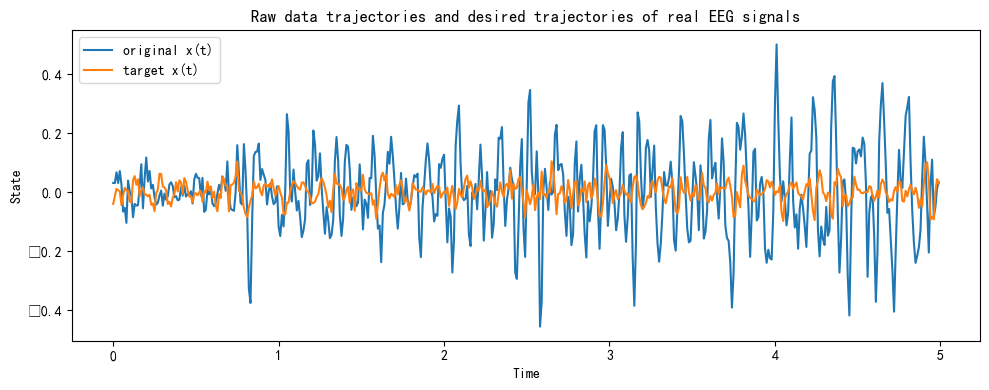

In [10]:
# 绘图
plt.figure(figsize=(10, 4))

plt.plot(t, original_data, label='original x(t)')
plt.plot(t, Y_desired, label='target x(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('Raw data trajectories and desired trajectories of real EEG signals')
plt.tight_layout()
plt.show()


#是否是周期的、混沌的（均匀截断——去掉噪声 庞加莱

In [11]:
# 计算傅里叶变换
def calculate_frequency_and_amplitude(signal, t):
    # 计算FFT
    N = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, t[1] - t[0])
    
    # 计算幅度谱
    amplitude_spectrum = np.abs(fft_signal)
    
    # 查找频率和最大幅值
    peak_frequency = freqs[np.argmax(amplitude_spectrum[1:])]  # 排除直流分量
    peak_frequency = np.abs(peak_frequency)
    
    # 计算平均振幅
    average_amplitude = np.mean(np.abs(signal))
    
    return peak_frequency, average_amplitude



# SDDE System Identification

In [12]:
def SI(train_pts,
        test_pts,
        term_train,
        X_train,
        alpha,  # Threshold for sparsity
        skip_pts=1,
        u_delay=0,
        print_code = False):
    # =============================================================================
    # Defining NG-RC parameters
    # =============================================================================


    # defining useful values for slicing the data    
    skip_pts = 0
    skip_train_pts = skip_pts + train_pts # all skip points and train points
    maxtime_pts = skip_pts + train_pts + test_pts-1 # all skip,train, and test points

    # defining NG-RC parameters
    d = 1 # input dimension: x
    k = 1 # number of time delay taps: i
    dlin = k*d # number of linear features for X: xi,yi,xim1,yim1
    # number of nonlinear features: 
    # 
    dtot = dlin + 1 + 2

    # =============================================================================
    # Linear feature creation
    # =============================================================================
    
    # defining feature vectors
    O_lin = np.zeros((dlin,maxtime_pts)) # linear feature vector
    O_1 = np.ones((1,maxtime_pts))
    O_total = np.zeros((dtot,maxtime_pts)) # total feature vector


    # =============================================================================
    # Nonlinear feature creation 
    # =============================================================================

    #lin
    x_i = X_train[:-1]
    O_lin[:,:] = x_i

    #nonlin 
    nonlinear_terms = {
        # 二次项
        "x_i^2": x_i**2,

        # 三次项
        "x_i^3": x_i**3,
    }

    # 将nonlinear_terms的值转换为numpy数组
    O_nonlin= np.array(list(nonlinear_terms.values()))


    O_total[:dlin,:] = O_lin # xi,xim1z
    O_total[dlin:dlin+1,:] = O_1
    # 将nonlinear_array的内容赋值给O_total
    O_total[dlin+1:,:] = O_nonlin#.squeeze()
    # =============================================================================
    # Learning weights
    # =============================================================================

    # Separating the total feature vector for training and testing
    O_train = O_total[:, skip_pts:skip_train_pts ]  # Training feature vector
    O_test = O_total[:, skip_train_pts:maxtime_pts ]  # Testing feature vector

    # Creating truth labels for training and testing sets for both x and y
    Y_train = term_train[ skip_pts :skip_train_pts]  # Ground truth for x during training
  
    Y_test = term_train[ skip_train_pts :maxtime_pts]  # Ground truth for x during testing
   

    # 使用LassoCV来自动选择最优的alpha
    lasso_cv = LassoCV(alphas=np.logspace(-alpha, 1, 50), max_iter=10000)
    lasso_cv.fit(O_train.T, Y_train)

    # 输出最优的alpha值
    best_alpha = lasso_cv.alpha_
    print("最优的alpha值:", best_alpha)

    train_prediction =  lasso_cv.predict(O_train.T)
    print('train_prediction:',len(train_prediction))
    # 获取回归系数
    W_out = lasso_cv.coef_


    # Compute the training RMSE for both x and y
    train_rmse = np.sqrt(np.mean((Y_train - train_prediction) ** 2))

    # Make prediction on testing data for both x and y
    test_prediction = W_out @ O_test

    # Compute the testing RMSE for both x and y
    test_rmse = np.sqrt(np.mean((Y_test - test_prediction) ** 2))
   
   

    # print(f"Train RMSE (x): {train_rmse_x}, Train RMSE (y): {train_rmse_y}")
    # print(f"Test RMSE (x): {test_rmse_x}, Test RMSE (y): {test_rmse_y}")
    train_track_error = term_train[skip_pts:skip_train_pts]-train_prediction 

    # keeping training and testing results in a dictionary
    train_test_dict = {'train_predict':train_prediction,
                       'train_true':Y_train,
                       'test_predict':test_prediction,
                       'test_true':Y_test,
                       'train_rmse':train_rmse,
                       'test_rmse': test_rmse,
                       'W_out':W_out,
                       'track_error':train_track_error}
    



    # =============================================================================
    # Print code to paste into Verilog file in Quartus
    # =============================================================================

    if print_code:
        print("Printing code:\n")
        # get the current date and time to mark when the weights were learned
        current_time = datetime.now()
        formatted_time = current_time.strftime("%m/%d/%Y %I:%M %p")


        print("Done printing code")
        print("//******************************************LOCAL PARAMETERS******************************************//\n")
        print(f"//Weights (trained on {formatted_time})")
        

        print("localparam data_length = " + str(data_length) + ";")
 
        
        print("\n//******************************************Train Output******************************************//\n")
        
        print("\n// KEEP OTHER DECLARATIONS controlledSTANT IN CODE\n")
            
        print(f"\n//Weights (trained on {formatted_time})")
        # Print non-zero elements of W_out[0] (corresponding to X)
        print("\n// Non-zero elements of W_out[0] (X):")
        non_zero_indices_x = np.where(np.abs(W_out) > 0)  # Indices where W_out[:, 0] is non-zero
        for idx in non_zero_indices_x:
            print(f"Index {idx} : Value {W_out[idx]}")
            

    return train_test_dict



## Kramers–Moyal formula

In [13]:
# 使用Kramers–Moyal formula 构造训练数据
x1 = data[1:]
x0 = data[:-1]

drift_term = (x1-x0)/t_sample
diffusion_term = (x1**2+x0**2-2*x0*x1)/t_sample


## drift term

In [14]:


# 稀疏阈值
a = 5

print_code = True
# show_plots = True
# save the training and testing results that correspond to the lowest testing error.
drift_system = SI(train_pts_id,
                    test_pts_id,
                    drift_term,
                    data,
                    a,
                    print_code=print_code)



最优的alpha值: 0.0012067926406393288
train_prediction: 1200
Printing code:

Done printing code
//******************************************LOCAL PARAMETERS******************************************//

//Weights (trained on 06/14/2025 04:03 PM)
localparam data_length = 500;

//******************************************Train Output******************************************//


// KEEP OTHER DECLARATIONS controlledSTANT IN CODE


//Weights (trained on 06/14/2025 04:03 PM)

// Non-zero elements of W_out[0] (X):
Index [0] : Value [-5.88784345]


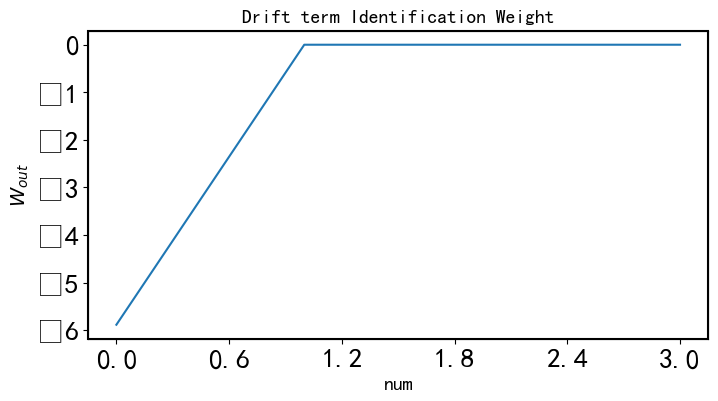

In [15]:
A = drift_system['W_out']
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(len(A.T)),A.T, c = 'C0',zorder = 1)

# setting x and y labels
ax.set_xlabel(r"num",fontsize = fontsize)
ax.set_ylabel(r"$W_{out}$",fontsize = fontsize)

# add title
ax.set_title('Drift term Identification Weight',fontsize=fontsize)

# setting x and y limits
# ax.set_xlim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)
# ax.set_ylim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)

# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)


# plotting figure
plt.show()

## diffusion term

In [16]:
# 稀疏阈值
b = 5

# save the training and testing results that correspond to the lowest testing error.
diff_system = SI(train_pts_id,
                    test_pts_id,
                    diffusion_term,
                    data,
                    b,
                    print_code=print_code)


最优的alpha值: 1e-05
train_prediction: 1200
Printing code:

Done printing code
//******************************************LOCAL PARAMETERS******************************************//

//Weights (trained on 06/14/2025 04:03 PM)
localparam data_length = 500;

//******************************************Train Output******************************************//


// KEEP OTHER DECLARATIONS controlledSTANT IN CODE


//Weights (trained on 06/14/2025 04:03 PM)

// Non-zero elements of W_out[0] (X):
Index [0 2 3] : Value [-0.11496917  4.02773463  0.03753035]


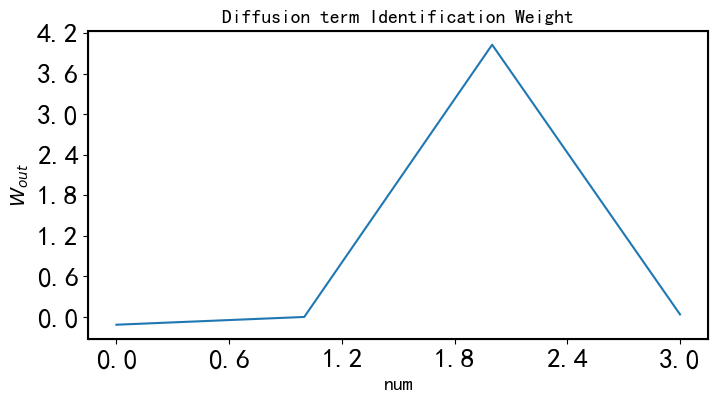

In [17]:
B = diff_system['W_out']
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(len(B.T)),B.T, c = 'C0',zorder = 1)

# setting x and y labels
ax.set_xlabel(r"num",fontsize = fontsize)
ax.set_ylabel(r"$W_{out}$",fontsize = fontsize)

# add title
ax.set_title('Diffusion term Identification Weight',fontsize=fontsize)


# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)

# plotting figure
plt.show()

## PLot

    train_test_dict = {'train_predict':train_prediction,
                       'train_true':Y_train,
                       'test_predict':test_prediction,
                       'test_true':Y_test,
                       'train_rmse':train_rmse,
                       'test_rmse': test_rmse,
                       'W_out':W_out,
                       'track_error':train_track_error}

In [18]:
fontsize = 18
# defining useful values for slicing the data    
skip_pts = 0
skip_train_pts = skip_pts + train_pts_id # all skip points and train points
maxtime_pts = skip_pts + train_pts_id + test_pts_id-1 # all skip,train, and test points

f_1 = drift_system['train_true']
f_1p= drift_system['train_predict']
f_2 = drift_system['test_true']
f_2p= drift_system['test_predict']

g_1 = diff_system['train_true']
g_1p= diff_system['train_predict']
g_2 = diff_system['test_true']
g_2p= diff_system['test_predict']

# 拼接训练和测试数据
f_true_all = np.concatenate((f_1, f_2))   # 真实 drift term
f_pred_all = np.concatenate((f_1p, f_2p)) # 预测 drift term
g2_true_all = np.concatenate((g_1, g_2))   
g2_pred_all = np.concatenate((g_1p, g_2p)) 

# f_data = fnn(torch.from_numpy(data.reshape(-1, 1)).float()).detach().numpy()
# g_data = gnn(torch.from_numpy(data.reshape(-1, 1)).float()).detach().numpy()
X_1 = data[skip_pts:skip_train_pts]
X_2 = data[skip_train_pts:maxtime_pts]

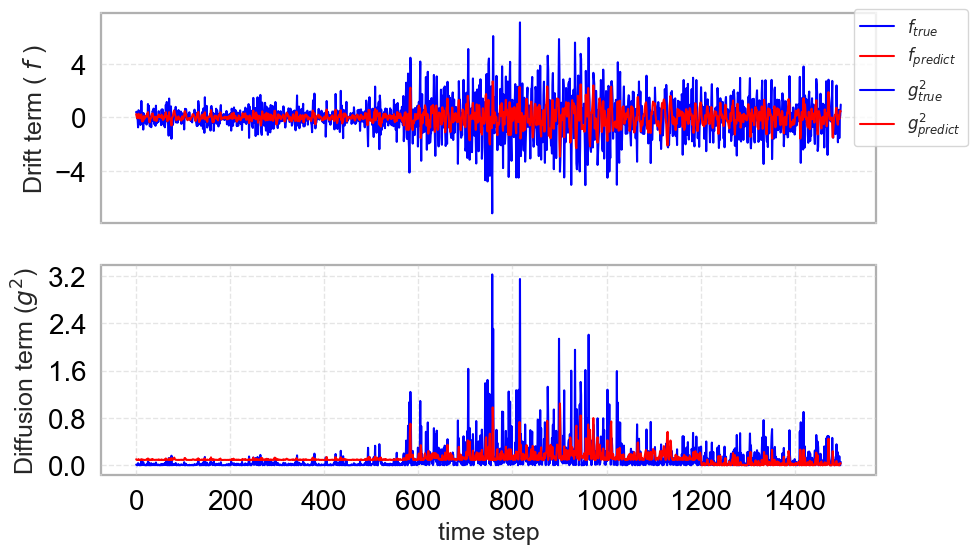

In [19]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(10,6))
axs[0].plot(f_true_all, c = 'blue', label = r'$f_{true}$')
axs[0].plot(f_pred_all, c = "red", label = r'$f_{predict}$')

axs[1].plot(g2_true_all, c = 'blue', label = r'$g^2_{true}$')
axs[1].plot(g2_pred_all, c = "red", label = r'$g^2_{predict}$')


# set x and y labels
axs[0].set_ylabel(r'Drift term ( $f$ )',fontsize=fontsize)
axs[1].set_ylabel(r'Diffusion term ($g^2$)',fontsize=fontsize)
axs[1].set_xlabel("time step",fontsize=fontsize)


for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))
    ax.tick_params(axis = 'x', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'x', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    
    # add boxes around plots
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(box_linewidth)
    ax.grid(True, linestyle='--', alpha=0.5)
# remove x ticks for top plot
axs[0].set_xticks([])


# set title
# fig.suptitle("Prediction on training data",fontsize=fontsize)

# add legend
fig.legend(bbox_to_anchor = (1,0.9),fontsize = 12)
# ,prop=font_prop
# show plot
plt.show()




In [20]:
# fig, axs = plt.subplots(2, 1, figsize=(10,6))
# axs[0].plot(data,f_data, c = 'blue', label = r'$f$')
# axs[1].plot(data,g_data, c = "red", label = r'$g$')

# # # set x and y labels
# # ax.set_ylabel('漂移项训练数据',fontsize=fontsize)
# axs[1].set_xlabel("系统状态x",fontsize=fontsize)


# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
# # ,prop=font_prop
# # show plot
# plt.show()

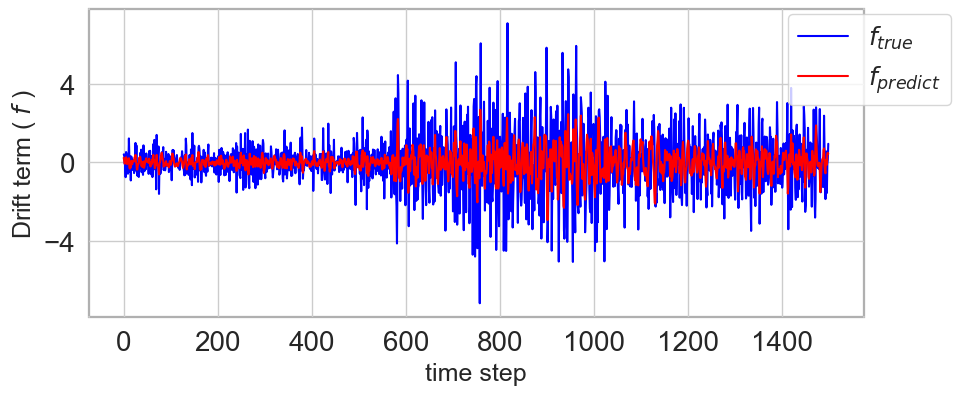

In [21]:

# =============================================================================
# Plotting training time-series 
# =============================================================================
    
# subplots

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(f_true_all, c = 'blue', label = r'$f_{true}$')
ax.plot(f_pred_all, c = "red", label = r'$f_{predict}$')

# set x and y labels
ax.set_ylabel(r'Drift term ( $f$ )',fontsize=fontsize)
ax.set_xlabel("time step",fontsize=fontsize)


# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)


# set title
# fig.suptitle("Prediction on training data",fontsize=fontsize)

# add legend
fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
# ,prop=font_prop
# show plot
plt.show()



# # =============================================================================
# # Plotting testing time-series 
# # =============================================================================
# # subplots
# fig, ax = plt.subplots(1, 1, figsize=(10,4))
# ax.plot(f_2, c = 'blue', label = r'$f_{true}$')
# ax.plot(f_2p, c = "red", label = r'$f_{predict}$')

# # set x and y labels
# ax.set_ylabel(r'Drift term ($f_{test}$)',fontsize=fontsize)
# ax.set_xlabel('time step',fontsize=fontsize)


# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)

# # set title
# # fig.suptitle("Prediction on testing data",fontsize=fontsize)

# # add legend
# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)

# # show plot
# plt.show()





In [22]:

# # =============================================================================
# # Plotting training time-series 
# # =============================================================================
    
# # subplots

# fig, ax = plt.subplots(1, 1, figsize=(10,4))
# ax.plot(X_1,f_1,'*', c = 'blue', label = r'$f_{true}$')
# ax.plot(X_1,f_1p, c = "red", label = r'$f_{predict}$')

# # set x and y labels
# ax.set_ylabel(r'Drift term ($f_{train}$)',fontsize=fontsize)
# ax.set_xlabel("State (X)",fontsize=fontsize)


# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)


# # set title
# # fig.suptitle("Prediction on training data",fontsize=fontsize)

# # add legend
# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
# # ,prop=font_prop
# # show plot
# plt.show()



# # =============================================================================
# # Plotting testing time-series 
# # =============================================================================
# # subplots
# fig, ax = plt.subplots(1, 1, figsize=(10,4))
# ax.plot(X_2,f_2,'*', c = 'blue', label = r'$f_{true}$')
# ax.plot(X_2,f_2p, c = "red", label = r'$f_{predict}$')

# # set x and y labels
# ax.set_ylabel(r'Drift term ($f_{test}$)',fontsize=fontsize)
# ax.set_xlabel('State (X)',fontsize=fontsize)


# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)

# # set title
# # fig.suptitle("Prediction on testing data",fontsize=fontsize)

# # add legend
# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)

# # show plot
# plt.show()





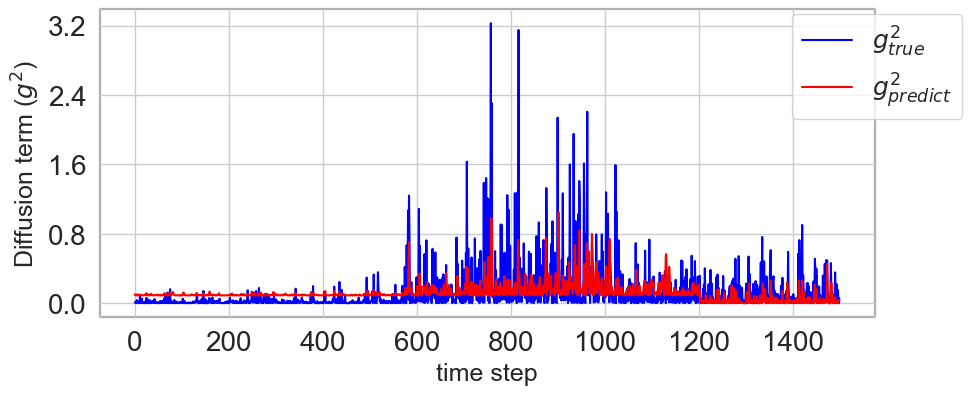

In [23]:

# =============================================================================
# Plotting training time-series 
# =============================================================================
    
# subplots

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(g2_true_all, c = 'blue', label = r'$g^2_{true}$')
ax.plot(g2_pred_all, c = "red", label = r'$g^2_{predict}$')

# set x and y labels
ax.set_ylabel(r'Diffusion term ($g^2$)',fontsize=fontsize)
ax.set_xlabel("time step",fontsize=fontsize)


# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)


# set title
# fig.suptitle("Prediction on training data",fontsize=fontsize)

# add legend
fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
# ,prop=font_prop
# show plot
plt.show()



# # =============================================================================
# # Plotting testing time-series 
# # =============================================================================
# # subplots
# fig, ax = plt.subplots(1, 1, figsize=(10,4))
# ax.plot(g_2, c = 'blue', label = r'$g^2_{true}$')
# ax.plot(g_2p, c = "red", label = r'$g^2_{predict}$')

# # set x and y labels
# ax.set_ylabel(r'Diffusion term ($g^2_{test}$)',fontsize=fontsize)
# ax.set_xlabel('time step',fontsize=fontsize)


# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)

# # set title
# # fig.suptitle("Prediction on testing data",fontsize=fontsize)

# # add legend
# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)

# # show plot
# plt.show()





In [24]:

# # =============================================================================
# # Plotting training time-series 
# # =============================================================================
    
# # subplots

# fig, ax = plt.subplots(1, 1, figsize=(10,4))
# ax.plot(X_1,g_1, '*', c = 'blue', label = r'$g^2_{true}$')
# ax.plot(X_1,g_1p, c = "red", label = r'$g^2_{predict}$')

# # set x and y labels
# ax.set_ylabel(r'Diffusion term ($g^2_{train}$)',fontsize=fontsize)
# ax.set_xlabel("State (X)",fontsize=fontsize)


# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)


# # set title
# # fig.suptitle("Prediction on training data",fontsize=fontsize)

# # add legend
# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)
# # ,prop=font_prop
# # show plot
# plt.show()



# # =============================================================================
# # Plotting testing time-series 
# # =============================================================================
# # subplots
# fig, ax = plt.subplots(1, 1, figsize=(10,4))
# ax.plot(X_2,g_2,'*', c = 'blue', label = r'$g^2_{true}$')
# ax.plot(X_2,g_2p, c = "red", label = r'$g^2_{predict}$')

# # set x and y labels
# ax.set_ylabel(r'Diffusion term ($g^2_{test}$)',fontsize=fontsize)
# ax.set_xlabel('State (X)',fontsize=fontsize)


# # adjust ticks
# ax.tick_params(axis='both', labelsize=ticksize)
# ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
# ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

# # draw box around plot
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(box_linewidth)

# # set title
# # fig.suptitle("Prediction on testing data",fontsize=fontsize)

# # add legend
# fig.legend(bbox_to_anchor = (1,0.9),fontsize = fontsize)

# # show plot
# plt.show()





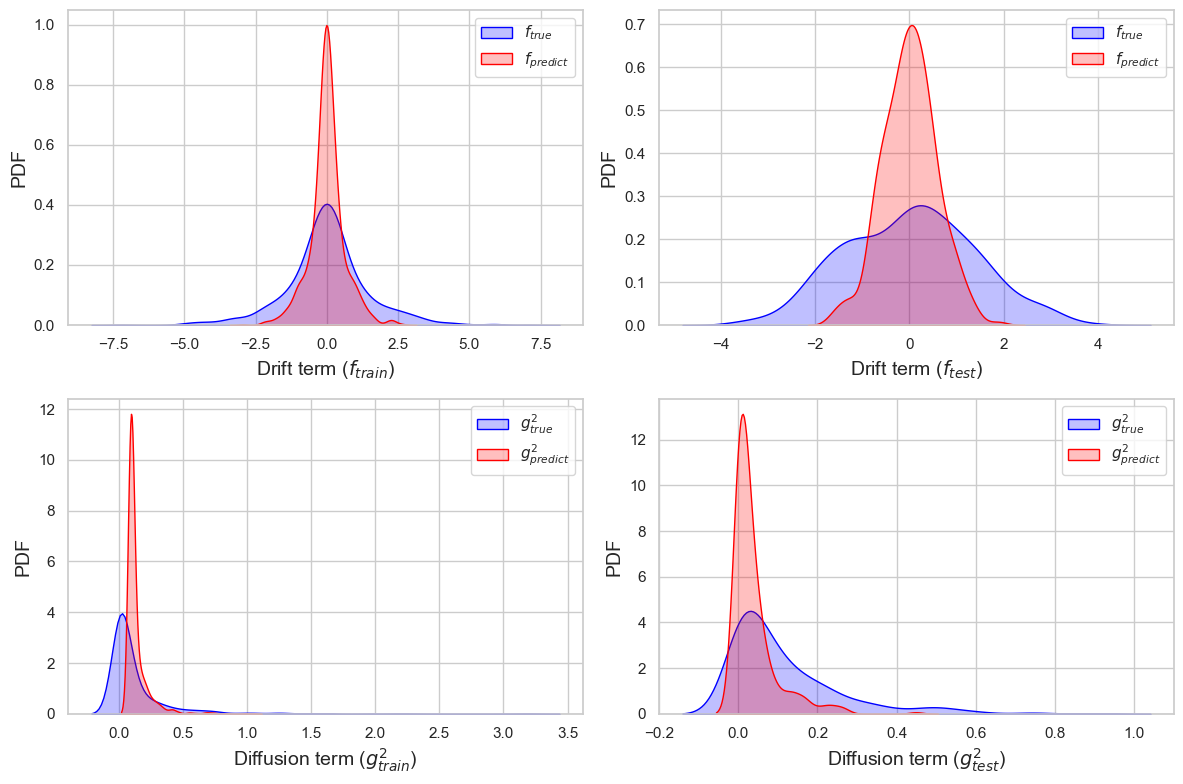

In [25]:
# 设置图像风格和字体属性（假设font_prop已定义）
sns.set(style="whitegrid")
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 如果中文显示有问题可添加此项
# plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题
fontsize = 14
# 创建2x2子图布局
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ====================== 第一行：漂移项 ======================
# 训练误差（左上）
sns.kdeplot(f_1, label=r'$f_{true}$', color='blue', fill=True, ax=axs[0,0])
sns.kdeplot(f_1p, label=r'$f_{predict}$', color="red", fill=True, ax=axs[0,0])
axs[0,0].legend()
axs[0,0].set_xlabel(r'Drift term ($f_{train}$)', fontsize=fontsize)
axs[0,0].set_ylabel('PDF', fontsize=fontsize)

# 测试误差（右上）
sns.kdeplot(f_2, label=r'$f_{true}$', color='blue', fill=True, ax=axs[0,1])
sns.kdeplot(f_2p, label=r'$f_{predict}$', color="red", fill=True, ax=axs[0,1])
axs[0,1].legend()
axs[0,1].set_xlabel(r'Drift term ($f_{test}$)', fontsize=fontsize)
axs[0,1].set_ylabel('PDF', fontsize=fontsize)

# ====================== 第二行：扩散项 ======================
# 训练误差（左下）
sns.kdeplot(g_1, label=r'$g^2_{true}$', color='blue', fill=True, ax=axs[1,0])
sns.kdeplot(g_1p, label=r'$g^2_{predict}$', color="red", fill=True, ax=axs[1,0])
axs[1,0].legend()
axs[1,0].set_xlabel(r'Diffusion term ($g^2_{train}$)', fontsize=fontsize)
axs[1,0].set_ylabel('PDF', fontsize=fontsize)

# 测试误差（右下）
sns.kdeplot(g_2, label=r'$g^2_{true}$', color='blue', fill=True, ax=axs[1,1])
sns.kdeplot(g_2p, label=r'$g^2_{predict}$', color="red", fill=True, ax=axs[1,1])
axs[1,1].legend()
axs[1,1].set_xlabel(r'Diffusion term ($g^2_{test}$)', fontsize=fontsize)
axs[1,1].set_ylabel('PDF', fontsize=fontsize)

# 调整布局
plt.tight_layout()
plt.show()

# Generate perturbation $u$ and plot disturbed system

In [26]:
a = 2.5
u_per = - a * np.random.normal(0,1,train_test_depth)

# # plot perturbation
# fontsize = 20
# fig, ax = plt.subplots(1, 1, figsize=(8,4))    
# ax.plot(u_per, color = 'orange',linewidth=1, label = r'$u_{perturbation}$')
# # set x and y limits
# ax.set_xlim(0,train_test_depth)

# # set x and y labels
# ax.set_xlabel('Time Step',fontsize=fontsize)
# ax.set_ylabel('Perturbation Value',fontsize=fontsize)

# # set title
# ax.set_title('Perturbation for training and testing',fontsize=fontsize)

# # adjust ticks
# ax.tick_params(axis='both', labelsize=fontsize)    
# fig.legend()
# # show plot
# plt.show()

In [27]:
def generate_perturbed_data(xy0, W_drift, W_diffusion, U, data_length,n):

    # defining NG-RC parameters
    d = 1 # input dimension: x
    k = 1 # number of time delay taps: i,i-1
    dlin = k*d # number of linear features for X: xi,yi,xim1,yim1
    # number of nonlinear features: 
    # 
    dtot = dlin + 1 + 2

    X_per = np.zeros((data_length+1))
    X_per[1] = xy0
    
    # defining feature vectors
    O_lin = np.zeros((dlin)) # linear feature vector
    O_1 = np.ones((1))
    O_total = np.zeros((dtot)) # total feature vector

    # 创建噪声项
    N = np.zeros((data_length))
    S = np.zeros((data_length))

    np.random.seed(n)
    S = np.sqrt(dt) * np.random.randn(data_length)
    # 数值迭代生成数据
    for i in range(1,data_length):
    
        # 生成随机扰动
        # print(W_diffusion @ O_total)
        # print(np.sqrt(W_diffusion @ O_total))
        # N[i] = np.sqrt(W_diffusion @ O_total) * S[i]
        N[i] = np.sqrt(np.abs(W_diffusion @ O_total)) * S[i]
        # 漂移项与扩散项的近似（SINDy）
        x_i = X_per[i]
        O_lin[:] = x_i
        #nonlin 
        nonlinear_terms = {
            # 二次项
            "x_i^2": x_i**2,

            # 三次项
            "x_i^3": x_i**3,


        }
        # 将nonlinear_terms的值转换为numpy数组
        O_nonlin= np.array(list(nonlinear_terms.values()))

        O_total[:dlin] = O_lin # xi
        O_total[dlin:dlin+1] = O_1
        # 将nonlinear_array的内容赋值给O_total的后三十维
        O_total[dlin+1:] = O_nonlin

        # x_tensor = torch.from_numpy(np.array([x_i])).float()
        # print(x_tensor)
        # if x_tensor >-0.4:
        #     f = 0.5*W_drift @ O_total + 0.5*fnn(x_tensor).detach().numpy() + U[i]
        # else:
        #     f = W_drift @ O_total + U[i]
        # print(f)
       # 使用欧拉迭代公式更新状态
        f = W_drift @ O_total + U[i]
        X_per[i+1] = X_per[i] + f * dt +  N[i]



    return X_per[1:], N, S

In [28]:
xy0 = original_data[0]
# 生成扰动数据
X_per, noise_data, sto_data = generate_perturbed_data(xy0, A, B, u_per, train_test_depth,15)

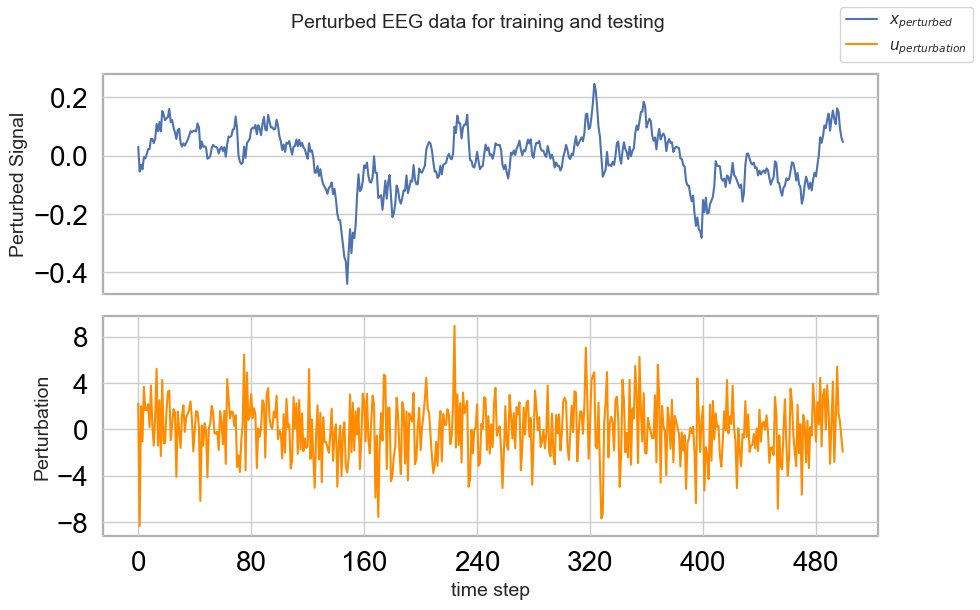

In [29]:
# creating figure
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# plot x and y
axs[0].plot(X_per, label=r'$x_{perturbed}$')

# plotting controlled u
axs[1].plot(u_per,c='darkorange',label = r"$u_{perturbation}$")

# axs[1].set_ylim(-2*max_uniform, 2*max_uniform)

# set x and y labels
axs[0].set_ylabel("Perturbed Signal",fontsize = fontsize)
axs[1].set_ylabel("Perturbation",fontsize = fontsize)
axs[1].set_xlabel('time step',fontsize=fontsize)


# adjust ticks for for bottom plots
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))
    ax.tick_params(axis = 'x', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'x', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    
    # add boxes around plots
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(box_linewidth)

# remove x ticks for top plot
axs[0].set_xticks([])

# setting title
fig.suptitle("Perturbed EEG data for training and testing",fontsize=fontsize)

# adding a legend
# fig.legend(bbox_to_anchor=(1.02,0.8),fontsize=fontsize)
fig.legend()
# adjust subplot spacing
plt.subplots_adjust(hspace=0.1)

# plotting figure
plt.show()

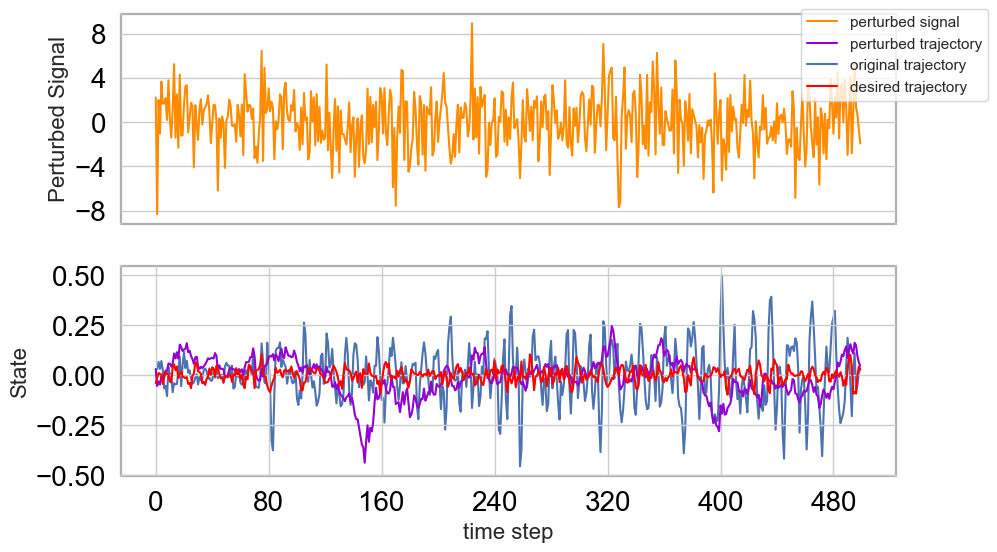

In [30]:
fontsize = 16
# plot attractor
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# plotting controlled u
axs[0].plot(u_per,c='darkorange',label = 'perturbed signal')


axs[1].plot(X_per[train_test_depth-data_length:], c = attractor_color,zorder = 10, label = 'perturbed trajectory')
axs[1].plot(original_data, c = 'C0',zorder = -20, label = 'original trajectory')
axs[1].plot( Y_desired, c = 'red',zorder = 20, label = 'desired trajectory')
# setting x and y labels
axs[0].set_ylabel("Perturbed Signal",fontsize = fontsize)
axs[1].set_ylabel('State',fontsize = fontsize)
axs[1].set_xlabel('time step',fontsize = fontsize)

# adjust ticks for for bottom plots
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))
    ax.tick_params(axis = 'x', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'x', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='minor', direction='out', length=tick_length, width=tick_width, colors='black')
    ax.tick_params(axis = 'y', which='major', direction='out', length=tick_length, width=tick_width, colors='black')
    
    # add boxes around plots
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(box_linewidth)

# remove x ticks for top plot
axs[0].set_xticks([])

# setting title
# ax.set_title("Demonstration diagrams of the data",fontsize=fontsize)
# axs[1].set_ylim(-2*max_uniform, 2*max_uniform)

# plotting figure
fig.legend(bbox_to_anchor = (1,0.9))
plt.show()

In [31]:
# 计算x和y的频率和平均振幅
freq_o, amp_o = calculate_frequency_and_amplitude(original_data, t)
freq_t, amp_t = calculate_frequency_and_amplitude(Y_desired, t)
freq_c, amp_c = calculate_frequency_and_amplitude(X_per[train_test_depth-data_length:], t)

print(f"Signal original: Frequency = {freq_o} Hz, Average Amplitude = {amp_o}")
print(f"Signal target: Frequency = {freq_t} Hz, Average Amplitude = {amp_t}")
print(f"Signal controlled: Frequency = {freq_c} Hz, Average Amplitude = {amp_c}")

Signal original: Frequency = 6.800000000000001 Hz, Average Amplitude = 0.10475822149720591
Signal target: Frequency = 7.6000000000000005 Hz, Average Amplitude = 0.026595636831293654
Signal controlled: Frequency = 0.2 Hz, Average Amplitude = 0.07440817124279049


# Training and Testing the NG-RC Model

In [32]:
def training_and_testing(ridge_param,
                         train_pts,
                         test_pts,
                         X_train,
                         U_train,
                         N_train,
                         skip_pts=1,
                         m=0,
                         u_delay=0,
                         show_plots = False,
                         print_code = False):
    # =============================================================================
    # Defining controlled and NG-RC parameters
    # =============================================================================
    
    # # defining controlled gain matrix    
    # K = np.zeros((1,2))
    # # The gain is chosen to be -3.0 to represent the largest magnitude it may ever become,
    # # higher gains like this are used in linear controlled, whereas the NG-RC controlledlers fail
    # # if the gain is |K|>1.0. The fixed-point form for K is chosen based on the maximum value
    # # needed to be represented, so that is why the maximum magnitude is chosen here.
    # K[0,0] = 0.0 # gain for x (not used in this experiment)
    # K[0,1] = -0.3 # gain for y (控制目标)

    # defining useful values for slicing the data    
    skip_pts = 0
    skip_train_pts = skip_pts + train_pts # all skip points and train points
    maxtime_pts = skip_pts + train_pts + test_pts # all skip,train, and test points

    # defining NG-RC parameters
    d = 1 # input dimension: x
    k = 2 # number of time delay taps: i,i-1
    dlin = k*d # number of linear features for X: xi,xim1
    dlinu = 1 # number of linear features for u: uxi
    dlinn = 1 # number of linear features for u: noise_xi
    # number of nonlinear features: 
    # 
    dtot = dlin + dlinu + dlinn + 1 + 7

    # =============================================================================
    # Linear feature creation
    # =============================================================================
    
    # defining feature vectors
    O_lin = np.zeros((dlin,maxtime_pts)) # linear feature vector
    O_lin_u = np.zeros((dlinu,maxtime_pts)) # linear feature vector (u)
    O_lin_n = np.zeros((dlinn,maxtime_pts)) # linear feature vector (u)
    O_total = np.zeros((dtot,maxtime_pts)) # total feature vector
    O_1 = np.ones((1,maxtime_pts))

    # create delayed copy of (x,y)   
    xy_delayed = np.insert(X_train[:-1],0,0,axis=0)

            
    # fill in the u feature vector for all times
    # O_lin_u[0,:] = U_train [0,:] # uxi
    # O_lin_u[1,:] = U_train [1,:] # uyi
    # O_lin_n[0,:] = N_train [0,:].squeeze()
    # O_lin_n[1,:] = N_train [1,:].squeeze()
    O_lin_u = U_train 
    O_lin_n = N_train
    # =============================================================================
    # Nonlinear feature creation 
    # =============================================================================

    #lin
    x_i = X_train
    x_im1 = xy_delayed
    O_lin[:,:] = np.array([x_i, x_im1]).squeeze()

    #nonlin 
    nonlinear_terms = {
        # 二次项
        "x_i^2": x_i**2,
        "x_i * x_im1": x_i * x_im1,
        "x_im1^2": x_im1**2,

        # 三次项
        "x_i^3": x_i**3,
        "x_i^2 * x_im1": x_i**2 * x_im1,
        "x_i * x_im1^2": x_i * x_im1**2,
        "x_im1^3": x_im1**3
    }
    # 将nonlinear_terms的值转换为numpy数组
    O_nonlin= np.array(list(nonlinear_terms.values()))


    O_total[:dlinu,:] = O_lin_u # uxi,uyi,ux_im1,uy_im1
    O_total[dlinu:dlinu+dlinn,:] = O_lin_n # noise
    O_total[dlinu+dlinn:dlinu+dlinn+dlin,:] = O_lin # xi,yi,xim1,yim1
    O_total[dlinu+dlinn+dlin:dlinu+dlinn+dlin+1,:] = O_1 # xi,yi,xim1,yim1
    
    # 将nonlinear_array的内容赋值给O_total的后三十维
    O_total[dlinu+dlin+dlinn+1:,:] = O_nonlin#.squeeze()
    # =============================================================================
    # Learning weights
    # =============================================================================

    # Separating the total feature vector for training and testing
    O_train = O_total[:, skip_pts:skip_train_pts - m]  # Training feature vector
    O_test = O_total[:, skip_train_pts:maxtime_pts - m]  # Testing feature vector

    # Creating truth labels for training and testing sets for both x and y
    Y_train = O_lin[0, skip_pts + m:skip_train_pts]  # Ground truth for x during training

    Y_test = O_lin[0, skip_train_pts + m:maxtime_pts]  # Ground truth for x during testing

    # Computing output weights using ridge regression for both x and y
    W_out = (Y_train) @ O_train.T @ np.linalg.pinv(O_train @ O_train.T + ridge_param * np.identity(dtot))

    # Separating learned weights into Wu and WF
    W_u = W_out[0]

    # Finding Wu^-1 for both x and y
    W_u_inv = 1/W_u

    # Make prediction on training data for both x and y
    train_prediction = W_out @ O_train

    # Compute the training RMSE for both x and y
    train_rmse = np.sqrt(np.mean((Y_train - train_prediction) ** 2))

    # Make prediction on testing data for both x and y
    test_prediction = W_out @ O_test

    # Compute the testing RMSE for both x and y
    test_rmse_x = np.sqrt(np.mean((Y_test - test_prediction) ** 2))

    # print(f"Train RMSE (x): {train_rmse_x}, Train RMSE (y): {train_rmse_y}")
    # print(f"Test RMSE (x): {test_rmse_x}, Test RMSE (y): {test_rmse_y}")

    # keeping training and testing results in a dictionary
    train_test_dict = {'ridge_param':ridge_param,
                       'train_rmse':train_rmse,
                       'test_rmse': test_rmse_x,
                       'W_out':W_out,
                       'W_u_inv':W_u_inv,
                       'prediction_train':train_prediction,
                       'true_train':Y_train,
                       'prediction_test':test_prediction,
                       'true_test':Y_test}

    # =============================================================================
    # Plotting training and testing predictions
    # =============================================================================
    
    if show_plots:
        fontsize = 18
        # =============================================================================
        # Plotting training time-series 
        # =============================================================================

        # subplots
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
        ax.plot(Y_train,'*', c = attractor_color, label = r'$x_{true}$')
        ax.plot(train_prediction, c = "black", label = r'$x_{predict}$')
        # set x and y labels
        ax.set_ylabel('State X',fontsize=fontsize)
        ax.set_xlabel('time step',fontsize=fontsize)
        
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
            
        # # remove ticks on V1 and V2 plots
        # axs[0].set_xticks([])
        
        # adjust subplot spacing
        plt.subplots_adjust(hspace=0.1)
        
        # set title
        # fig.suptitle("Prediction on training data",fontsize=fontsize)
        
        # add legend
        fig.legend(bbox_to_anchor = (1,0.8),fontsize=fontsize)
        # prop=font_prop
        
        # show plot
        plt.show()

        # =============================================================================
        # Plotting training error
        # =============================================================================

        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.plot(train_prediction - Y_train,c='C0', label = r'error $x_{train}$')
       
        # set x and y labels
        ax.set_ylabel(" error",fontsize=fontsize)
        ax.set_xlabel("time step",fontsize=fontsize)
        
        # adjust ticks
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
        
        # add title
        ax.set_title("Training error",fontsize=fontsize)
        
        # show plot
        fig.legend()
        plt.show()

        
        # =============================================================================
        # Plotting testing time-series 
        # =============================================================================

        # subplots
        fig, axs = plt.subplots(2, 1, figsize=(10,8))
        axs[0].plot(Y_test, c = 'C0', label = r"true $x_{test}$")
        axs[0].plot(test_prediction, c = "red", label = r"predicted $x_{test}$")
        axs[1].plot(O_lin_u[skip_train_pts:maxtime_pts - m], label = r"u", c = "darkorange")
        # set x and y labels
        axs[0].set_ylabel(r"$x_{test}$",fontsize=fontsize)
        axs[1].set_ylabel(r"u ",fontsize=fontsize)
        axs[1].set_xlabel("time step",fontsize=fontsize)
        
        for ax in axs.flat:
            # adjust ticks
            ax.tick_params(axis='both', labelsize=ticksize)
            ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

            # draw box around plot
            ax.patch.set_edgecolor('black')  
            ax.patch.set_linewidth(box_linewidth)
            
        # remove ticks on V1 and V2 plots
        axs[0].set_xticks([])
        
        # adjust subplot spacing
        plt.subplots_adjust(hspace=0.1)
        
        # set title
        fig.suptitle("Prediction on testing data",fontsize=fontsize)
        
        # add legend
        fig.legend(bbox_to_anchor = (1.2,0.9),fontsize = fontsize)
        
        # show plot
        plt.show()
        
        # =============================================================================
        # Plotting testing error 
        # =============================================================================

        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.plot(test_prediction - Y_test,c='C0', label = r'error $x_{test}$')
        # set x and y labels
        ax.set_ylabel("error ",fontsize=fontsize)
        ax.set_xlabel("time step",fontsize=fontsize)
        
        # adjust ticks
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))

        # draw box around plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(box_linewidth)
        
        # add title
        ax.set_title("Testing error",fontsize=fontsize)
        
        # show plot
        fig.legend()
        plt.show()

    

    # =============================================================================
    # Print code to paste into Verilog file in Quartus
    # =============================================================================

    if print_code:
        print("Printing code:\n")
        # get the current date and time to mark when the weights were learned
        current_time = datetime.now()
        formatted_time = current_time.strftime("%m/%d/%Y %I:%M %p")


        print("Done printing code")
        print("//******************************************LOCAL PARAMETERS******************************************//\n")
        print(f"//Weights (trained on {formatted_time})")
        

        print("localparam data_length = " + str(data_length) + ";")
 
        
        print("\n//******************************************Train Output******************************************//\n")
        
        print("\n// KEEP OTHER DECLARATIONS controlledSTANT IN CODE\n")
            
        print(f"\n//Weights (trained on {formatted_time})")
        print("//ridge parameter: " + str(ridge_param))
        print("W_u_inv = " + str(W_u_inv)) 
        print("W_u = " + str(W_out[0]))
        print("W_n = " + str(W_out[1] )) 
        print("W_x = " + str(W_out[2] ) )
        print("W_xm1 = " + str(W_out[3] ) )

    return train_test_dict



# Find the ridge parameter that gives lowest testing error

In [33]:
def evaluate_param(ridge_param_array, train_pts, test_pts, 
                   perturbed_data, u_per, noise, m=1):
    """
    Evaluate the best test ridge parameter for given ridge parameters.
    
    Parameters:
    - ridge_param_array: Array of ridge parameters to evaluate.
    - train_pts: Number of training points.
    - test_pts: Number of testing points.
    - perturbed_data: The perturbed data used for training and testing.
    - u_per: The controlled input for the model.
    - m: The number of steps ahead for prediction (default is 1).

    Returns:
    - best_test_ridges: The list of best test ridge parameters corresponding to each ridge parameter.
    - spectral_radii: The list of spectral radii corresponding to each ridge parameter.
    """

    # 保存不同岭回归参数的最佳结果
    results = []
    # 定义用于存储训练和测试 RMSE 的数组
    rmse_train_array = np.zeros(len(ridge_param_array))
    rmse_test_array = np.zeros(len(ridge_param_array))
    best_ridge_array = []  # To store the best ridge parameter under the controlledstraint

    # 遍历不同的岭回归参数
    for i in range(len(ridge_param_array)):
        ridge_param = ridge_param_array[i]

        # 执行训练和测试
        train_test_dict_i = training_and_testing(ridge_param,
                                                 train_pts,
                                                 test_pts,
                                                 perturbed_data,
                                                 u_per,
                                                 noise,
                                                 m=m)

        # 保存训练和测试的 RMSE
        rmse_train_array[i] = train_test_dict_i['train_rmse']
        rmse_test_array[i] = train_test_dict_i['test_rmse']

        # 获取W_u_inv
        W_u_inv = train_test_dict_i['W_u_inv']

        # 仅当W_u_inv小于100时才考虑该岭回归参数
        if np.linalg.norm(W_u_inv) < 200:  # 判断W_u_inv的范数是否小于100
            best_ridge_array.append(ridge_param)
        else:
            rmse_test_array[i] = np.inf  # 如果W_u_inv大于100，则将该参数的RMSE设置为无穷大，排除在外

    # 找到最小的测试 RMSE
    best_test_rmse = np.min(rmse_test_array)

    # 找到对应的最佳岭回归参数
    best_test_ridge = ridge_param_array[np.argmin(rmse_test_array)]

    # 保存对应的最佳测试结果
    train_test_dict = training_and_testing(best_test_ridge,
                                            train_pts,
                                            test_pts,
                                            perturbed_data,
                                            u_per,
                                            noise,
                                            m=m,
                                            show_plots=False,
                                            print_code=False)

    # 计算并保存
    W_u_inv = train_test_dict['W_u_inv']
    print('最小的测试 RMSE:', best_test_rmse)
    print('对应的最佳岭回归参数:', best_test_ridge)
    print('W_u_inv:', W_u_inv)

    return best_test_ridge


In [34]:

m = 0 # one step ahead prediction
# 定义搜索区间和总次数
ridge_param_array = np.logspace(-5,1,50)

# serachleak best_test_ridges
best_test_ridge = evaluate_param(
    ridge_param_array, train_pts, test_pts, X_per[:t2], u_per[:t2], noise_data[:t2], m)



最小的测试 RMSE: 0.00627260719420538
对应的最佳岭回归参数: 0.19306977288832497
W_u_inv: 194.08539920425628


In [35]:
print_code = True
# save the training and testing results that correspond to the lowest testing error.
train_test_dict = training_and_testing(best_test_ridge,
                                       train_pts,
                                       test_pts,
                                       X_per[:t2],
                                       u_per[:t2],
                                       noise_data[:t2],
                                       m=m,
                                       show_plots=False, 
                                       print_code=print_code)
print(train_test_dict['train_rmse'])

Printing code:

Done printing code
//******************************************LOCAL PARAMETERS******************************************//

//Weights (trained on 06/14/2025 04:03 PM)
localparam data_length = 500;

//******************************************Train Output******************************************//


// KEEP OTHER DECLARATIONS controlledSTANT IN CODE


//Weights (trained on 06/14/2025 04:03 PM)
//ridge parameter: 0.19306977288832497
W_u_inv = 194.08539920425628
W_u = 0.00515237109076709
W_n = 0.14295013162846765
W_x = 0.5195320557674418
W_xm1 = 0.39994036824889073
0.00782681440176342


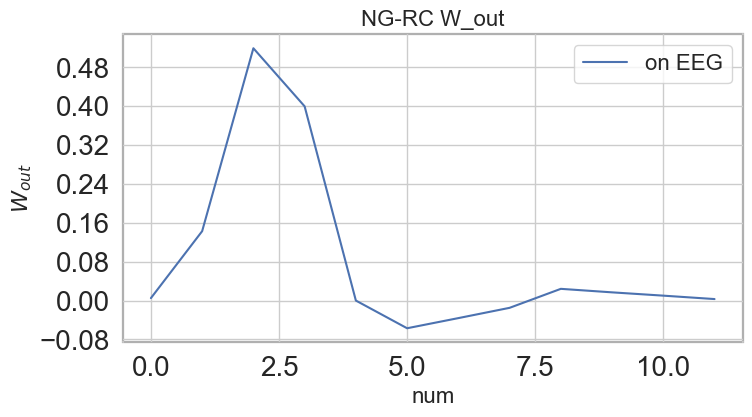

In [36]:
A = train_test_dict['W_out']
# Perform SVD
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(len(A.T)),A.T, c = 'C0',zorder = 1, label = 'on EEG')

# setting x and y labels
ax.set_xlabel(r"num",fontsize = fontsize)
ax.set_ylabel(r"$W_{out}$",fontsize = fontsize)

# add title
ax.set_title('NG-RC W_out',fontsize=fontsize)

# setting x and y limits
# ax.set_xlim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)
# ax.set_ylim(FP.SM1_12_TYPE.lower,FP.SM1_12_TYPE.upper)

# adjust ticks
ax.tick_params(axis='both', labelsize=ticksize)
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_attractor))
ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_attractor))

# draw box around plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(box_linewidth)

# add legend
ax.legend(bbox_to_anchor = (1,1),fontsize=fontsize)

# plotting figure
plt.show()

# Do control

In [37]:
def do_controlled(W_u_inv, Weight, W_drift, W_diffusion,
                   X_original, Y_desired, sto_term, K, controlled_length, a,b):
    """

    
    Parameters:
        K (numpy.ndarray): The controlled gain matrix (2x2).
        delay_level (int): The amount of delay in microsecontrolledds to add before
        the controlled perturbation is applied.
        task (int): Specifies the desired signal (1: original, 2: USS, 3: random).
        feedback_linearization (int): Whether the controlledler is strictly
        linear (0) or controlledtains nonlinear terms (1).
        Y_desired (numpy.ndarray): desired signal in digital form.
        
    Returns:
        controlled_dict (dict): A dictionary controlledtaining controlled data, desired signal,
        controlled series, controlled RMSE, and time array.
    """
    

 

    # Load pre-trained weights
    W_N = Weight[1]  
    W_X = Weight[2:]  

    # NG-RC parameters
    d = 1  # input dimension: x
    k = 2  # number of time delay taps
    dlin = k * d  # number of linear features for X
    
    dX = dlin + 1 + 7  # total features including nonlinear terms

    # =============================================================================
    # feature creation
    # =============================================================================
    
    O_X = np.zeros((dX,1)) # 去掉控制u_i、u_im1的其他 feature vector
    O_identify = np.zeros((4,1))
    O_N = np.zeros((1))
    #初始条件
    u_controlled = np.array([0])
    e_i = np.array([0])
    X_controlled = np.zeros((controlled_length))
    X_predicted = np.zeros((controlled_length))
    X_controlled[:b] = X_original[:b]
    X_predicted[:a] = X_original[:a]
    O_1 = np.ones((1))
    #储存轨迹和控制
    
    error_series = e_i
    controlled_series = u_controlled
    #迭代更新(只更新一步，根据结果可调整)
    for i in range(controlled_length-1):#data_length-1

        if i >= b:
            # 计算控制序列
            x_i = X_controlled[i]
            x_im1 = X_controlled[i-1]
            # Linear features
            O_lin = np.array([x_i, x_im1]) 
            
            # Nonlinear features
            nonlinear_terms = {
                # 二次项
                "x_i^2": x_i**2,
                "x_i * x_im1": x_i * x_im1,
                "x_im1^2": x_im1**2,

                # 三次项
                "x_i^3": x_i**3,
                "x_i^2 * x_im1": x_i**2 * x_im1,
                "x_i * x_im1^2": x_i * x_im1**2,
                "x_im1^3": x_im1**3
            }
            
            # 将nonlinear_terms的值转换为numpy数组
            O_nonlin= np.array(list(nonlinear_terms.values()))
            
            # Total feature vector
            O_X[:dlin] = O_lin[:, np.newaxis] # xi,yi,xim1,yim1
            O_X[dlin:dlin+1] = O_1[:, np.newaxis]
            O_X[dlin+1:] = O_nonlin[:, np.newaxis]
            O_identify = np.array([x_i, 1, x_i**2, x_i**3])

            # 生成noise base
            O_N = np.sqrt(np.abs(W_diffusion @ O_identify))* sto_term[i]
            # Calculate prediction error and update controlled input
            e_i = Y_desired[i] - X_controlled[i]
            # print(i,'---e_i.shape:',e_i,'---u_controlled:',u_controlled, '----Y_desired[i]:',Y_desired[i], '----X_controlled[i]:',X_controlled[ i])
            # print('---W_u_inv:',W_u_inv,'---W_X:',W_X,'---O_X:',O_X, '---W_N:',W_N,'---O_N:',O_N)     
            u_controlled = W_u_inv * (Y_desired[i + 1] - W_X @ O_X - W_N * O_N + K * e_i)
            # print(i,'---e_i:',e_i,'---u_controlled',u_controlled)
            # print('---Y_desired[:, i + 1]:',Y_desired[:, i + 1],'---O_X:',O_X)
            error_series = np.hstack((error_series, e_i))
            controlled_series = np.hstack((controlled_series, u_controlled))
            # print(controlled_series.shape)
            # x_tensor = torch.from_numpy(np.array([x_i])).float()
            # 动态演化
            f_x = W_drift @ O_identify

            f = f_x #+ fnn(x_tensor).item()
            #控制时模拟当前状态下的系统
            X_controlled[i+1] = X_controlled[i] + (f + u_controlled) * dt + np.sqrt(np.abs(W_diffusion @ O_identify)) * sto_term[i]
        elif i>=a-1:
            x_i = X_controlled[i]
            # x_tensor = torch.from_numpy(np.array([x_i])).float()
            O_identify = np.array([x_i, 1, x_i**2, x_i**3])
            # 动态演化
            f_x = W_drift @ O_identify
            #控制时模拟当前状态下的系统
            f = f_x #+ fnn(x_tensor).item()
            # X_controlled[i+1] = X_controlled[i] + f_x * dt + np.sqrt(np.abs(W_diffusion @ O_identify)) * sto_term[i]
            X_predicted[i+1] = X_controlled[i] + f * dt + np.sqrt(np.abs(W_diffusion @ O_identify)) * sto_term[i]
            
            # print(i,'---X_predicted[i+1]:',X_predicted[i+1])
        

    # calculate the controlled RMSE 
    controlled_rmse = np.sqrt(np.mean((Y_desired[b-1:-1] - X_controlled[b-1:-1])**2))
    predicted_rmse = np.sqrt(np.mean((X_original[a-1:b] - X_predicted[a-1:b])**2))
    # Store controlled data in a dictionary
    
    # 填充长度为a的0控制
    zeros = np.zeros((b))
    controlled_result = np.hstack((zeros, controlled_series))
    errors = np.hstack((zeros, error_series))
    # print('X_controlled.shape:',X_controlled.shape)
    # print('Y_desired.shape:',Y_desired.shape)
    # print('controlled_result.shape:',controlled_result.shape)
    # print('controlled_rmse:',controlled_rmse)
    # print('errors.shape:',errors.shape)

    controlled_dict = {'Data_controlled':X_controlled,
                       'Data_predicted':X_predicted,
                        'Y_desired':Y_desired,
                        'controlled_series':controlled_result,
                        'controlled_rmse':controlled_rmse,
                        'predicted_rmse':predicted_rmse,
                        'controlled error':errors
                        }


    return controlled_dict

# control system

In [38]:
# set controlled parameters
K = -0.02
# The gain is chosen to be -3.0 to represent the largest magnitude it may ever become,
# higher gains like this are used in linear controlled, whereas the NG-RC controlledlers fail
# if the gain is |K|>1.0. The fixed-point form for K is chosen based on the maximum value
# needed to be represented, so that is why the maximum magnitude is chosen here.

delay_level = 0 # set the added delay in the controlled loop in microsecontrolledds

# determine whether the controlledler is linear or uses NG-RC (1:NG-RC)
feedback_linearization = 1

W_u_inv = train_test_dict['W_u_inv']
W_out = train_test_dict['W_out']
A = drift_system['W_out']
B = diff_system['W_out']
controlled_dict = do_controlled(W_u_inv,
                                W_out, 
                                A,
                                B,
                                original_data,
                                Y_desired,
                                sto_data,
                                K,
                                data_length,
                                t1,
                                t2)

C:\Users\cheng\AppData\Local\Temp\ipykernel_18584\1665445329.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_controlled[i+1] = X_controlled[i] + (f + u_controlled) * dt + np.sqrt(np.abs(W_diffusion @ O_identify)) * sto_term[i]


# Plot control results

In [39]:
train_data = train_test_dict['prediction_test']
train_data.shape

(200,)

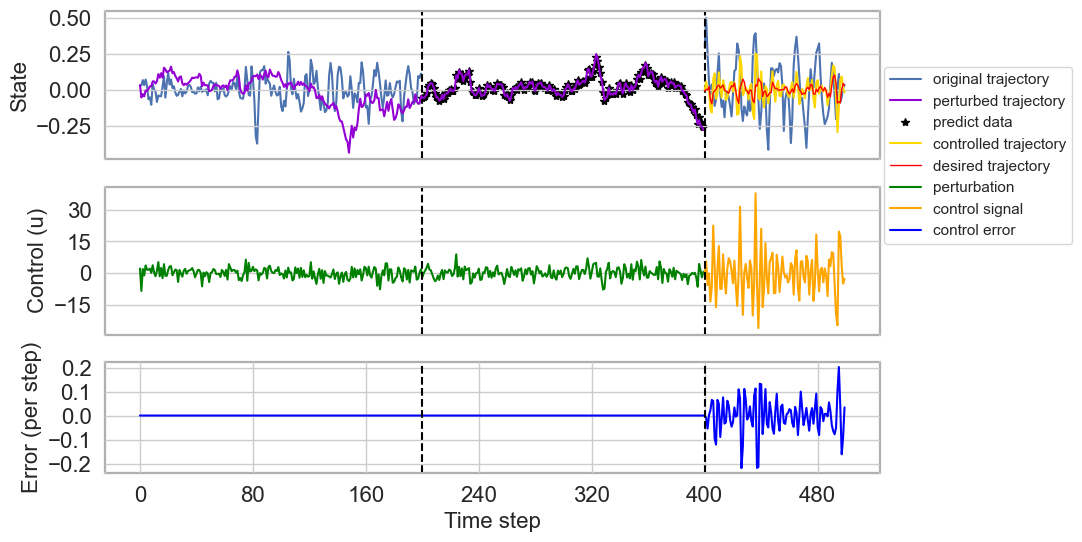

In [40]:
import matplotlib.gridspec as gridspec

fontsize = 16

# 创建 figure，并使用 gridspec 设定高度比例
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[4, 4, 3])  # 第一行占比 2，后两行各占比 1

axs = [fig.add_subplot(gs[i]) for i in range(3)]  # 创建 3 个子图

# 绘制第 1 行（状态轨迹）
axs[0].plot(time_array[:t1], original_data[:t1], c='b', zorder=-10, label='original trajectory')
axs[0].plot(time_array[:t2], X_per[:t2], c=attractor_color, zorder=10, label='perturbed trajectory')
axs[0].plot(time_array[t1:t2], train_data, '*', c='black', zorder=-10, label='predict data')
axs[0].plot(time_array[t2:data_length], original_data[t2:data_length], c='b', zorder=-10)
axs[0].plot(time_array[t2:data_length], controlled_dict['Data_controlled'][t2:data_length], c='gold', zorder=10, label='controlled trajectory')
axs[0].plot(time_array[t2:data_length], controlled_dict['Y_desired'][t2:data_length], c='red', label='desired trajectory', zorder=20, lw=1, alpha=1.0)
axs[0].axvline(x=t1, linestyle='dashed', c='black')
axs[0].axvline(x=t2, linestyle='dashed', c='black')

# 绘制第 2 行（控制信号）
axs[1].plot(time_array[:t2], u_per[:t2], c='green', label='perturbation')
axs[1].plot(time_array[t2:data_length], controlled_dict['controlled_series'][t2:data_length], c='orange', label='control signal')
axs[1].axvline(x=t1, linestyle='dashed', c='black')
axs[1].axvline(x=t2, linestyle='dashed', c='black')

# 绘制第 3 行（控制误差）
axs[2].plot(time_array[:data_length], controlled_dict['controlled error'][:data_length], c='blue', label='control error')
axs[2].axvline(x=t1, linestyle='dashed', c='black')
axs[2].axvline(x=t2, linestyle='dashed', c='black')

# 设置轴标签
axs[0].set_ylabel('State', fontsize=fontsize)
axs[1].set_ylabel('Control (u)', fontsize=fontsize)
axs[2].set_ylabel('Error (per step)', fontsize=fontsize)
axs[2].set_xlabel('Time step', fontsize=fontsize)

# 调整刻度
for ax in axs:
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbinsx_time_series))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbinsy_time_series))
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(box_linewidth)

# 移除 x 轴刻度标签
axs[0].set_xticks([])
axs[1].set_xticks([])

# 调整子图间距
plt.subplots_adjust(hspace=0.2)

# 添加图例
fig.legend(bbox_to_anchor=(1.1, 0.8))

# 显示图像
plt.show()


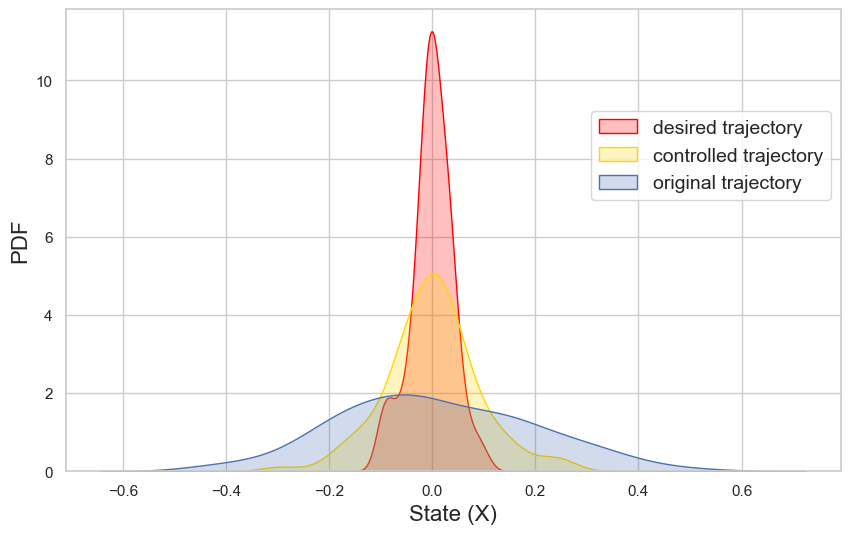

In [41]:
# Plot (KDE)

# 绘制 KDE 密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(controlled_dict['Y_desired'][ t2: data_length], label='desired trajectory', color="red", fill=True)
sns.kdeplot(controlled_dict['Data_controlled'][ t2:data_length], label = 'controlled trajectory', color='gold', fill=True)
sns.kdeplot(original_data[ t2:data_length], label = 'original trajectory', color= 'b', fill=True)


# 设置图例和标签
plt.legend(bbox_to_anchor=(1,0.8),fontsize = 14)
# plt.title('KDE Density Plot Comparison')
plt.xlabel('State (X)',fontsize = fontsize)
plt.ylabel('PDF',fontsize = fontsize)

# 显示图像
plt.show()

In [42]:
print('预测RMSE: ',controlled_dict['predicted_rmse'])
print('控制RMSE: ',controlled_dict['controlled_rmse'])

预测RMSE:  0.1331180529345371
控制RMSE:  0.07339591845021427


In [43]:
# 计算x和y的频率和平均振幅
freq_o, amp_o = calculate_frequency_and_amplitude(original_data, t)
freq_t, amp_t = calculate_frequency_and_amplitude(Y_desired, t)
freq_c, amp_c = calculate_frequency_and_amplitude(controlled_dict['Data_controlled'], t)

print(f"Signal original: Frequency = {freq_o} Hz, Average Amplitude = {amp_o}")
print(f"Signal target: Frequency = {freq_t} Hz, Average Amplitude = {amp_t}")
print(f"Signal controlled: Frequency = {freq_c} Hz, Average Amplitude = {amp_c}")

Signal original: Frequency = 6.800000000000001 Hz, Average Amplitude = 0.10475822149720591
Signal target: Frequency = 7.6000000000000005 Hz, Average Amplitude = 0.026595636831293654
Signal controlled: Frequency = 6.800000000000001 Hz, Average Amplitude = 0.08742727229531215


In [44]:
# # plot target perturbation
# fontsize = 10
# fig, ax = plt.subplots(1, 1, figsize=(8,4))   
# start_time =  t1
# t2 =  data_length-start_time #maximum = data_length-start_time
# error = controlled_dict['controlled error']
# ax.plot(time_array[start_time : start_time+t2], error[start_time : start_time+t2], color = 'blue',linewidth=2, label = r'error $e_x$')
# ax.axvline(x=start_time,linestyle='dashed',c='black')
# # set x and y limits
# ax.set_xlim(start_time,start_time+t2)
# # ax.set_xlim(start_time,start_time+10)
# # ax.set_xlim(data_length+t12,data_length+t12+10)
# # ax.set_xlim(t22+t13,t22+t13+10)
# # set x and y labels
# ax.set_xlabel('Time Step',fontsize=fontsize)
# ax.set_ylabel('Error per step',fontsize=fontsize)

# # set title
# ax.set_title(f'Error for controlled in first {t2} steps',fontsize=fontsize)

# # adjust ticks
# ax.tick_params(axis='both', labelsize=fontsize)    
# plt.legend()
# # show plot
# plt.show()